In [1]:
from sqlalchemy import create_engine
import getpass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks


from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
#FUNCTIONS

#check datatypes
def check_dtypes(dataframe):
    test =dataframe.dtypes
    x=0
    for i in range (len(dataframe.columns)):
        print(test[x]," ", dataframe.iloc[0][dataframe.columns[i]]," ",dataframe.columns[i])
        x+=1
    return()
    
#check datatypes
def check_dtypes2(dataframe):
    test =dataframe.dtypes
    x=0
    for i in range (len(dataframe.columns)):
        print("COL NAME: ",dataframe.columns[i])
        print("  TYPE: ",test[x])
        print("  NUMBER OF UNIQUE VALUES: ", dataframe[dataframe.columns[i]].nunique())
        print("  % OF UNIQUE VALUES: ", (len(pd.unique(dataframe[dataframe.columns[i]]))/len(dataframe[dataframe.columns[i]]))*100 )
        print("  Values: ",pd.unique(dataframe[dataframe.columns[i]]))
        print("  MODE: ",dataframe[dataframe.columns[i]].mode())
        print()
        x+=1
    return()
#dealing with null values

#null values info
def null_find(dataframe):
    null_df = pd.DataFrame(round(dataframe.isna().sum()/len(dataframe),4)*100)
    null_df = null_df.reset_index()
    null_df.columns = ['header','percentage_nulls']
    return(null_df)
           
#null values reduction
def null_reduction(dataframe,porcentage):
    null_df=null_find(dataframe)
    columns_drop = null_df[null_df['percentage_nulls']>porcentage]['header']
    return dataframe.drop(columns_drop,axis=1)

# print non zero null columns

def print_nan(dataframe):
    null_df = null_find(dataframe)
    null_df = null_df[null_df['percentage_nulls']>0]
    print(null_df)
    return()



#Normalize (numerical).
def normaizer(dataframe):
    transformer = MinMaxScaler().fit(dataframe) 
    x_minmax = transformer.transform(dataframe)
    return(pd.DataFrame(x_minmax, index=dataframe.index, columns=dataframe.columns))


In [3]:
#Initializing connection to MYSQL server
connection_string = 'mysql+pymysql://root:' + getpass.getpass() + '@localhost/student_pro'
engine = create_engine(connection_string)



········


In [4]:
#selecting the database
engine.execute("USE student_pro")


# Initial data exploration

In [5]:
#checking number math students
result = engine.execute("""SELECT 
    COUNT(school)
FROM
    student_mat_data;""")
 
for row in result:
    print(row[0])

395


In [6]:
#Checking math students age rangue and distribution


result = engine.execute("""SELECT DISTINCT
    (age), COUNT(age) AS 'count'
FROM
    student_mat_data
GROUP BY age
ORDER BY age;""")
 
for row in result:
    print(row)

(15, 82)
(16, 104)
(17, 98)
(18, 82)
(19, 24)
(20, 3)
(21, 1)
(22, 1)


In [7]:
#checking number portuguese students
result = engine.execute("""SELECT 
    COUNT(school)
FROM
    student_por_data;""")
 
for row in result:
    
    print(row[0])

649


In [8]:
#Checking portuguese students age rangue and distribution


result = engine.execute("""SELECT DISTINCT
    (age), COUNT(age) AS 'count'
FROM
    student_por_data
GROUP BY age
ORDER BY age;""")
 
for row in result:
    print(row)

(15, 112)
(16, 177)
(17, 179)
(18, 140)
(19, 32)
(20, 6)
(21, 2)
(22, 1)


In [9]:
#creating a dataframe for math students 
data = pd.read_sql_query('SELECT * FROM student_pro.student_por_data', engine)

In [10]:
#viewing dataframe sample data and size
data

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


In [11]:
#checking data types for each column
check_dtypes(data)


object   GP   school
object   F   sex
int64   18   age
object   U   address
object   GT3   famsize
object   A   pstatus
int64   4   medu
int64   4   fedu
object   at_home   mjob
object   teacher   fjob
object   course   reason
object   mother   guardian
int64   2   traveltime
int64   2   studytime
int64   0   failures
object   yes   schoolsup
object   no   famsup
object   no   paid
object   no   activities
object   yes   nursery
object   yes   higher
object   no   internet
object   no   romantic
int64   4   famrel
int64   3   freetime
int64   4   goout
int64   1   Dalc
int64   1   Walc
int64   3   health
int64   4   absences
int64   0   G1
int64   11   G2
int64   11   G3


()

Changing categorical columns to object type

In [12]:
data = data.astype({'medu': object,'fedu': object})


In [13]:
#checking porcentage of unique values for each column
check_dtypes2(data)


COL NAME:  school
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.30816640986132515
  Values:  ['GP' 'MS']
  MODE:  0    GP
dtype: object

COL NAME:  sex
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.30816640986132515
  Values:  ['F' 'M']
  MODE:  0    F
dtype: object

COL NAME:  age
  TYPE:  int64
  NUMBER OF UNIQUE VALUES:  8
  % OF UNIQUE VALUES:  1.2326656394453006
  Values:  [18 17 15 16 19 22 20 21]
  MODE:  0    17
dtype: int64

COL NAME:  address
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.30816640986132515
  Values:  ['U' 'R']
  MODE:  0    U
dtype: object

COL NAME:  famsize
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.30816640986132515
  Values:  ['GT3' 'LE3']
  MODE:  0    GT3
dtype: object

COL NAME:  pstatus
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.30816640986132515
  Values:  ['A' 'T']
  MODE:  0    T
dtype: object

COL NAME:  medu
  TYPE:  o

()

In [14]:
#checking null values
null_find(data)

,header,percentage_nulls
0,school,0.0
1,sex,0.0
2,age,0.0
3,address,0.0
4,famsize,0.0
5,pstatus,0.0
6,medu,0.0
7,fedu,0.0
8,mjob,0.0
9,fjob,0.0


#Exploring the data

In [15]:
categoricals = data.select_dtypes(object)
numerical = data.select_dtypes(include = np.number)

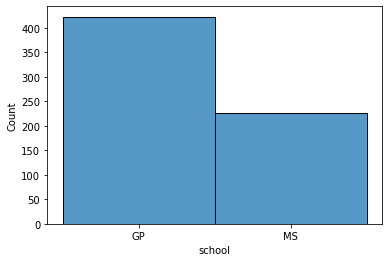

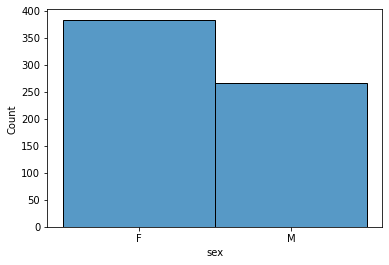

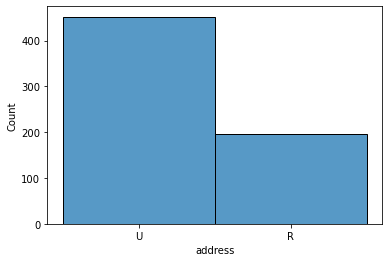

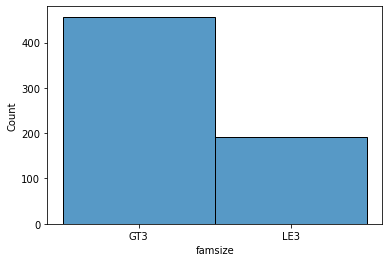

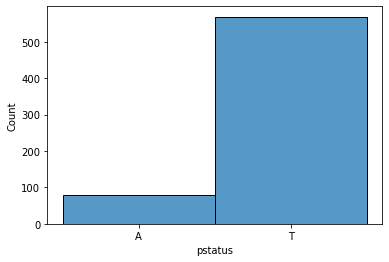

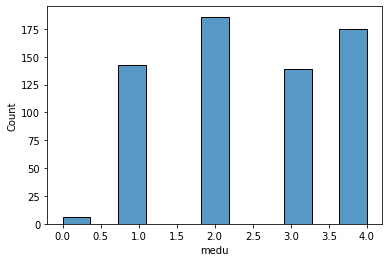

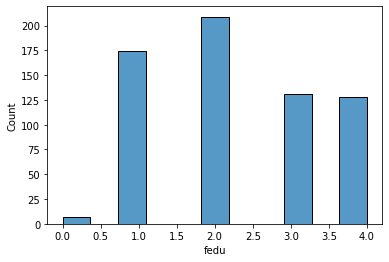

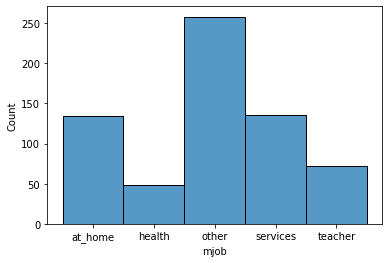

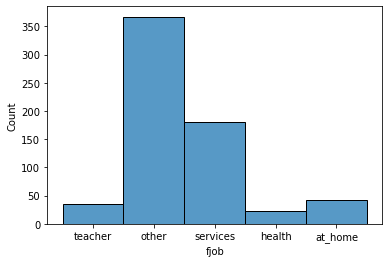

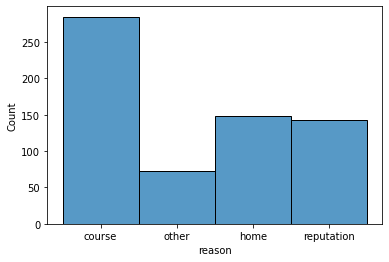

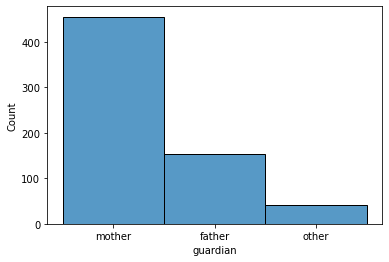

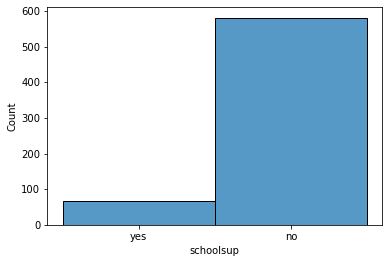

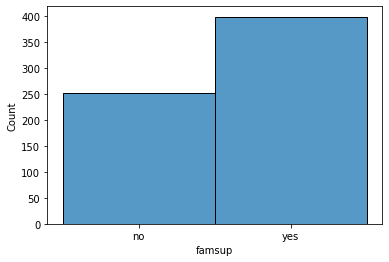

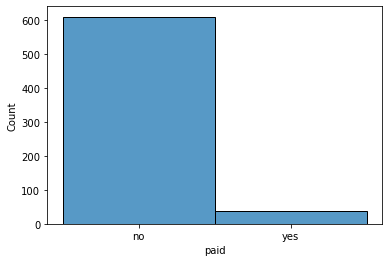

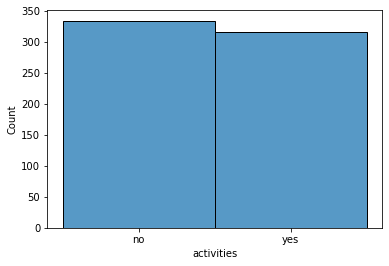

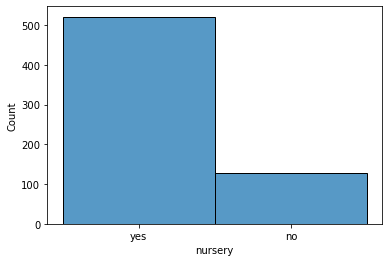

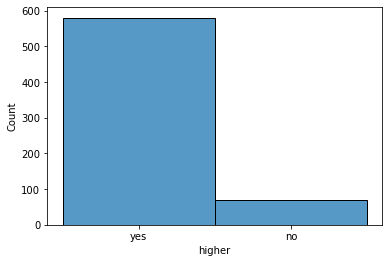

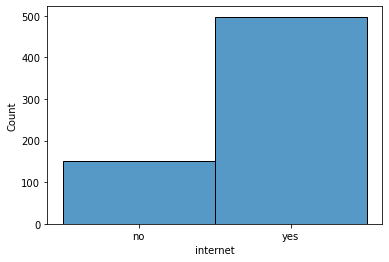

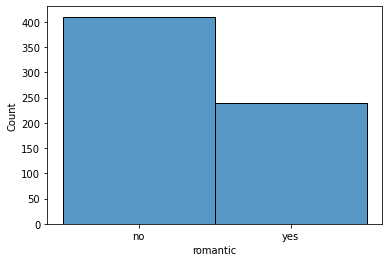

<Figure size 432x288 with 0 Axes>

In [16]:
for i in categoricals.columns:
    sns.histplot(categoricals[i])

    plt.figure(i)



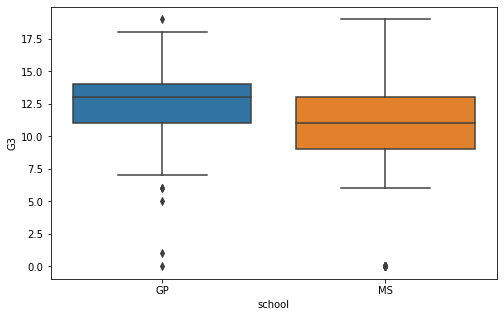

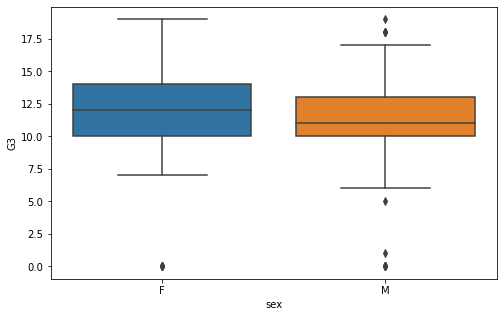

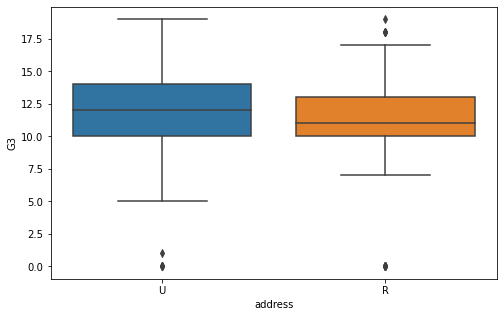

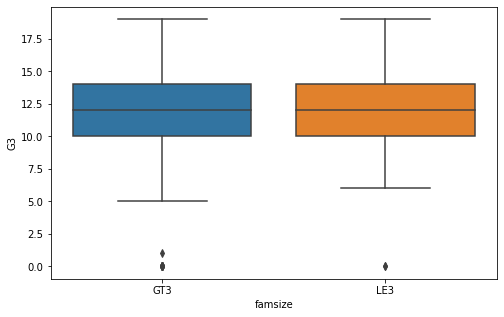

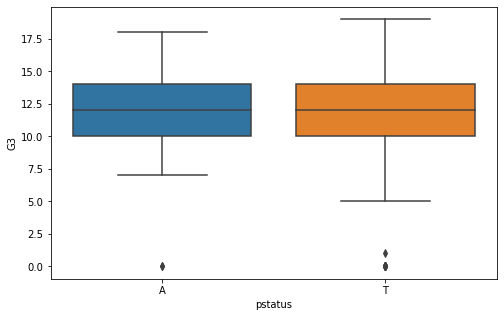

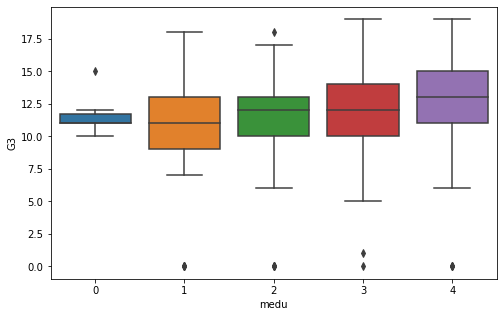

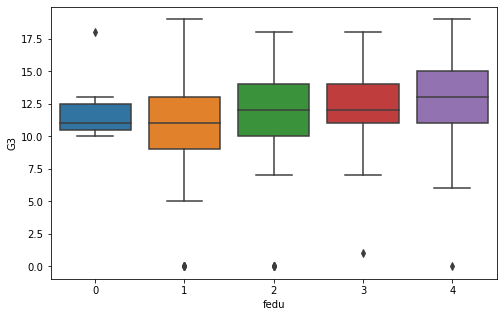

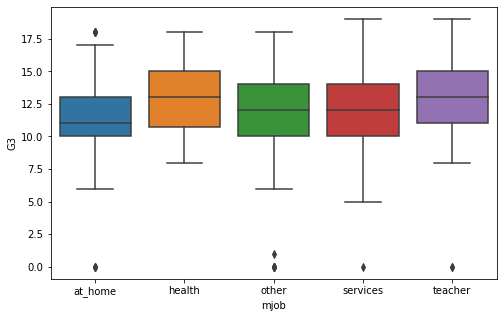

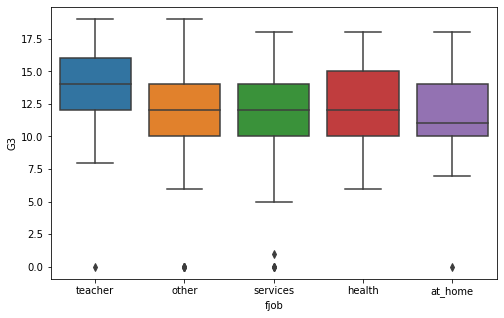

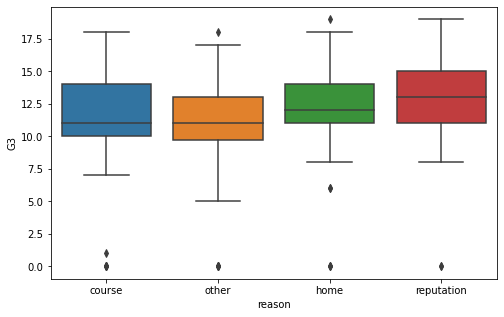

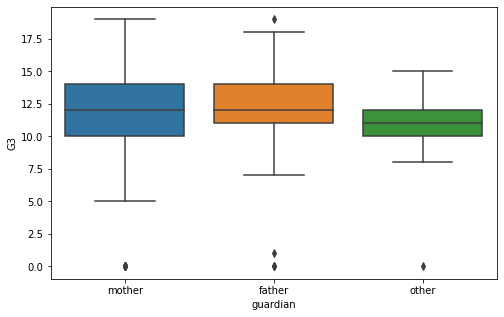

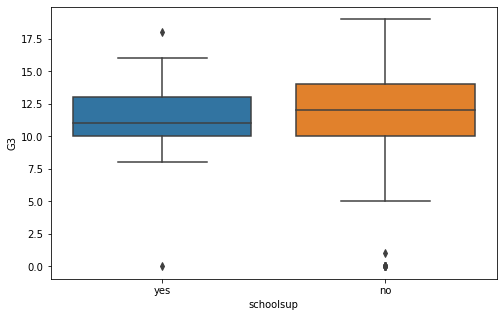

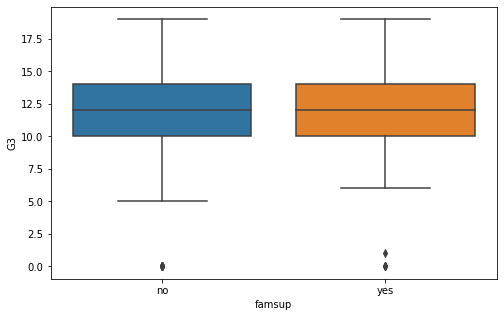

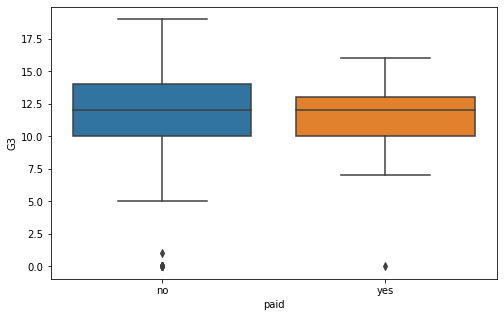

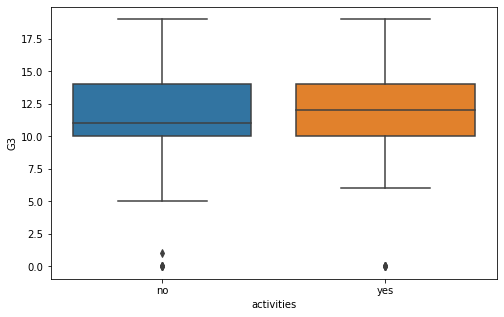

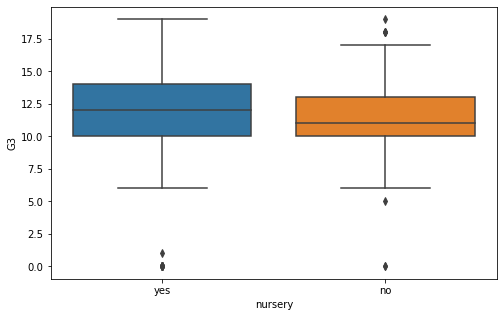

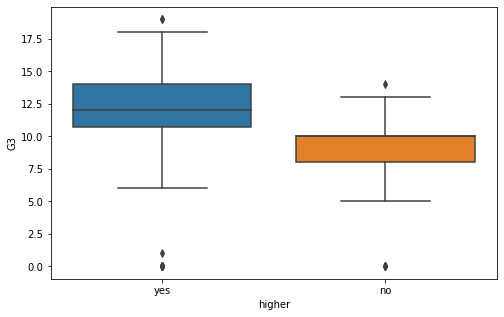

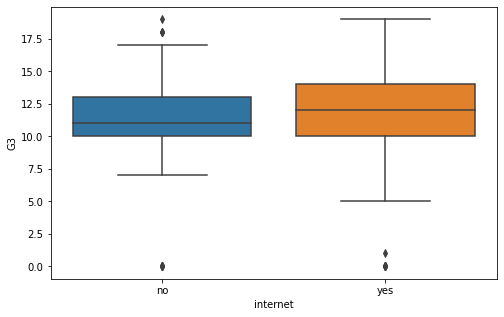

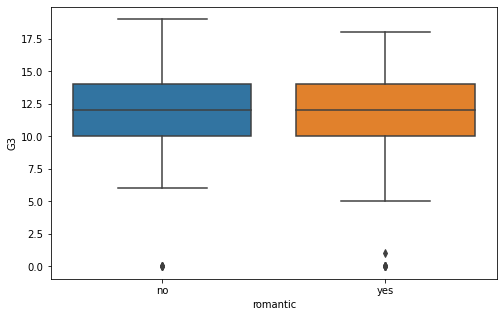

In [17]:
for col in categoricals:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=categoricals[col], y=data['G3'])

    plt.show()

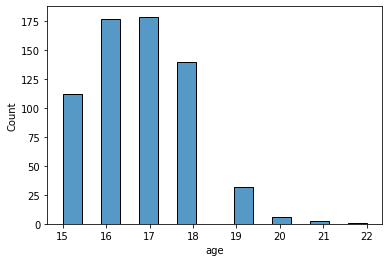

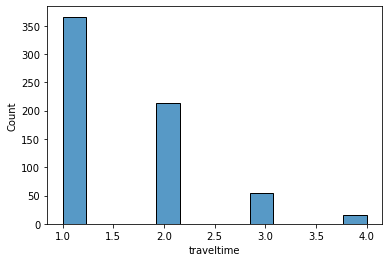

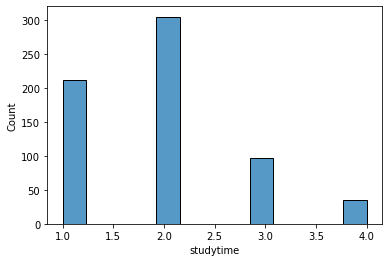

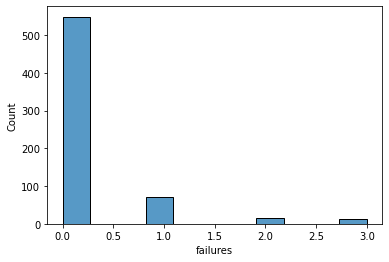

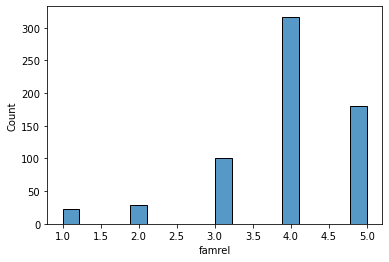

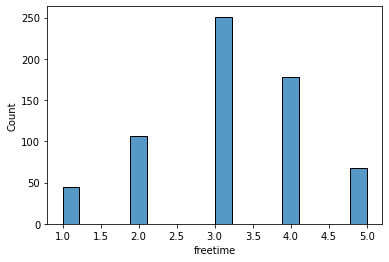

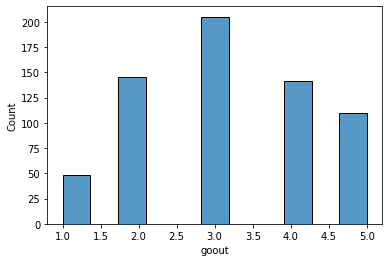

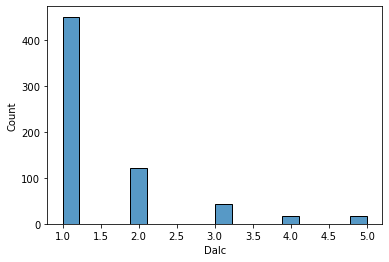

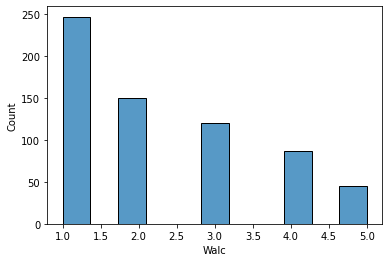

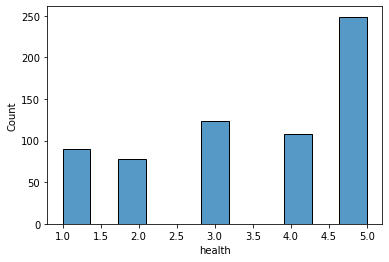

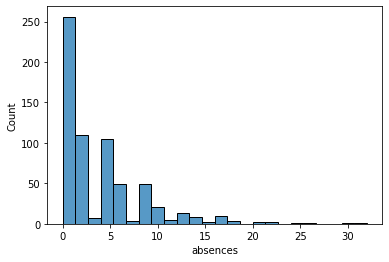

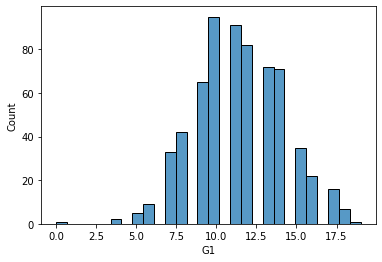

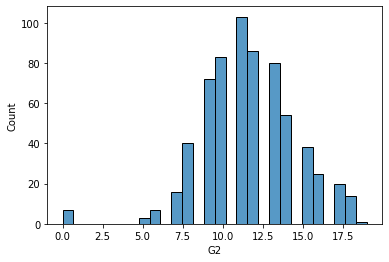

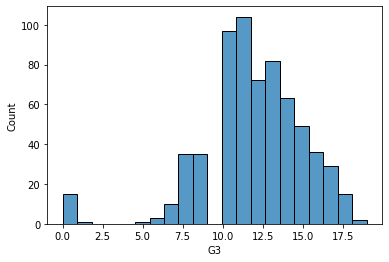

In [18]:
for head in numerical.columns:
    sns.histplot(numerical[head])

    plt.show()

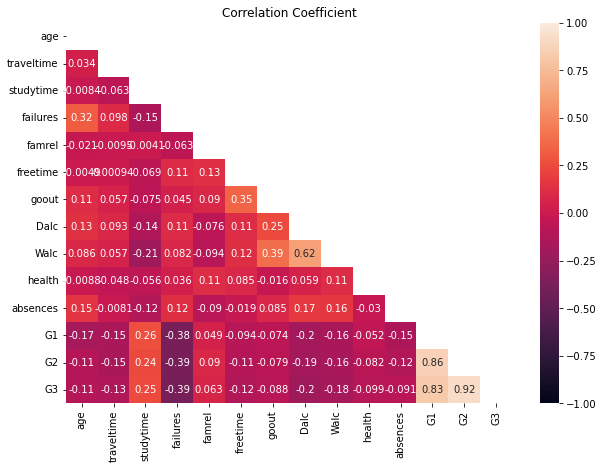

In [19]:

# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(numerical.corr(), dtype=bool))

# generate heatmap
sns.heatmap(numerical.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient')

plt.show()

In [20]:
data[data['paid']!='yes']

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


In [21]:
#dropping unknown data at the begining of the corse
data = data.drop(['absences'], axis = 1)

In [22]:
#dropping G1 and G2 because I'm only using the final grade G3 
data = data.drop(['G1','G2'], axis = 1)

In [23]:
data['paid'].value_counts()

no     610
yes     39
Name: paid, dtype: int64

<AxesSubplot:xlabel='paid', ylabel='Count'>

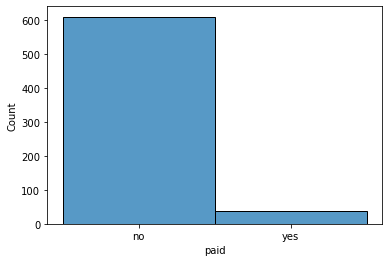

In [24]:
sns.histplot(data['paid'])


In [25]:
#dropping the students that took extra paid classes 
data = data[data['paid']!='yes']

In [26]:
data = data.drop(['paid'],axis = 1)

In [27]:
#from the 0 to 19 score returns yes or no depending on the score
def f1(row):
    if row['G3'] < 10:
        val = "NO"
    elif row['G3'] >= 10:
        val = "YES"
    return val

In [28]:
#creating a new column recommendation
data['recommendation'] = data.apply(f1, axis=1)

In [29]:
data

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,G3,recommendation
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,11,YES
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,11,YES
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,12,YES
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,14,YES
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,13,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,yes,no,5,4,2,1,2,5,10,YES
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,yes,no,4,3,4,1,1,1,16,YES
646,MS,F,18,U,GT3,T,1,1,other,other,...,no,no,1,1,1,1,1,5,9,NO
647,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,10,YES


In [30]:
#dropping G3 as it has a direct correlation with recommendation
data = data.drop(['G3'],axis = 1)

In [31]:
#checking target imbalance 
data['recommendation'].value_counts()

YES    519
NO      91
Name: recommendation, dtype: int64

<AxesSubplot:xlabel='recommendation', ylabel='Count'>

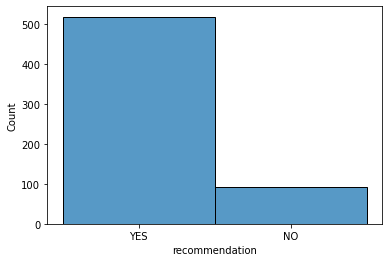

In [32]:
sns.histplot(data['recommendation'])


In [33]:
#the target is very imbalanced so I'm using smote for oversampling

Xf=data.drop(['recommendation'], axis=1)
y=data['recommendation']
Xf_num=Xf.select_dtypes(include = np.number)
Xf_cat = pd.get_dummies(Xf.select_dtypes(include = 'object'), drop_first=True)
Xf=pd.concat([Xf_num, Xf_cat], axis=1)



smote = SMOTE()
X_sm, y_sm = smote.fit_resample(Xf, y)

unique, counts = np.unique(y_sm, return_counts=True)
print(np.asarray((unique, counts)).T)

[['NO' 519]
 ['YES' 519]]


In [34]:
#Splitting the data for model training and testing
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

# testing different classification models

In [35]:
clf = RandomForestClassifier(max_depth=6, random_state=32)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          NO       0.92      0.90      0.91       146
         YES       0.91      0.93      0.92       166

    accuracy                           0.91       312
   macro avg       0.91      0.91      0.91       312
weighted avg       0.91      0.91      0.91       312



In [36]:
model = DecisionTreeClassifier(random_state=32)
model.fit( X_train, y_train )
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          NO       0.78      0.89      0.83       146
         YES       0.89      0.78      0.83       166

    accuracy                           0.83       312
   macro avg       0.84      0.84      0.83       312
weighted avg       0.84      0.83      0.83       312



In [37]:
model = LogisticRegression(max_iter = 1500)
model.fit( X_train, y_train )
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          NO       0.92      0.85      0.88       146
         YES       0.88      0.93      0.90       166

    accuracy                           0.89       312
   macro avg       0.90      0.89      0.89       312
weighted avg       0.90      0.89      0.89       312



In [38]:
#Random Forest and logistic regression are similiar, I'll try to fine tune random forest

In [39]:
#finding the best random state posible for the model
best_seed=0
acuracy=0
for x in range(200):
    clf = RandomForestClassifier(max_depth=6, random_state=x)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    if accuracy_score(y_test, predicted , normalize=False) > acuracy:
        acuracy = accuracy_score(y_test, predicted , normalize=False)
        best_seed = x
        
print('seed: ',best_seed)


seed:  74


In [40]:
por_model = RandomForestClassifier(max_depth=6, random_state=best_seed)
por_model.fit(X_train, y_train)
predicted = por_model.predict(X_test)
print(classification_report(y_test, predicted))


              precision    recall  f1-score   support

          NO       0.92      0.92      0.92       146
         YES       0.93      0.93      0.93       166

    accuracy                           0.92       312
   macro avg       0.92      0.92      0.92       312
weighted avg       0.92      0.92      0.92       312



In [41]:
#random forest is the final model

In [42]:
por_data = Xf.copy()

# Math data

In [43]:
#creating a dataframe for math students 
data = pd.read_sql_query('SELECT * FROM student_pro.student_mat_data', engine)

In [44]:
#viewing dataframe sample data and size
data

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [45]:
#checking data types for each column
check_dtypes(data)

object   GP   school
object   F   sex
int64   18   age
object   U   address
object   GT3   famsize
object   A   pstatus
int64   4   medu
int64   4   fedu
object   at_home   mjob
object   teacher   fjob
object   course   reason
object   mother   guardian
int64   2   traveltime
int64   2   studytime
int64   0   failures
object   yes   schoolsup
object   no   famsup
object   no   paid
object   no   activities
object   yes   nursery
object   yes   higher
object   no   internet
object   no   romantic
int64   4   famrel
int64   3   freetime
int64   4   goout
int64   1   Dalc
int64   1   Walc
int64   3   health
int64   6   absences
int64   5   G1
int64   6   G2
int64   6   G3


()

In [46]:
data = data.astype({'medu': object,'fedu': object})

In [47]:
#checking porcentage of unique values for each column
check_dtypes2(data)

COL NAME:  school
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.5063291139240507
  Values:  ['GP' 'MS']
  MODE:  0    GP
dtype: object

COL NAME:  sex
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.5063291139240507
  Values:  ['F' 'M']
  MODE:  0    F
dtype: object

COL NAME:  age
  TYPE:  int64
  NUMBER OF UNIQUE VALUES:  8
  % OF UNIQUE VALUES:  2.0253164556962027
  Values:  [18 17 15 16 19 22 20 21]
  MODE:  0    16
dtype: int64

COL NAME:  address
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.5063291139240507
  Values:  ['U' 'R']
  MODE:  0    U
dtype: object

COL NAME:  famsize
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.5063291139240507
  Values:  ['GT3' 'LE3']
  MODE:  0    GT3
dtype: object

COL NAME:  pstatus
  TYPE:  object
  NUMBER OF UNIQUE VALUES:  2
  % OF UNIQUE VALUES:  0.5063291139240507
  Values:  ['A' 'T']
  MODE:  0    T
dtype: object

COL NAME:  medu
  TYPE:  object

()

In [48]:
#checking null values
null_find(data)

,header,percentage_nulls
0,school,0.0
1,sex,0.0
2,age,0.0
3,address,0.0
4,famsize,0.0
5,pstatus,0.0
6,medu,0.0
7,fedu,0.0
8,mjob,0.0
9,fjob,0.0


In [49]:
#Exploring the data

In [50]:
categoricals = data.select_dtypes(object)
numerical = data.select_dtypes(include = np.number)

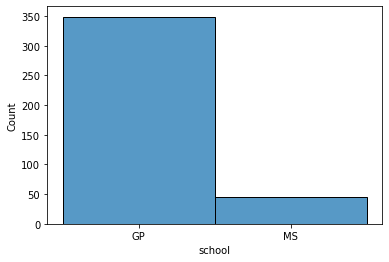

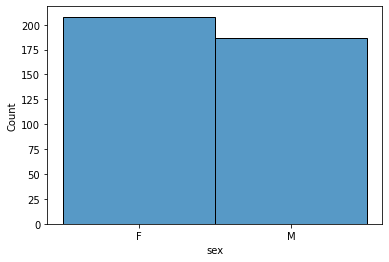

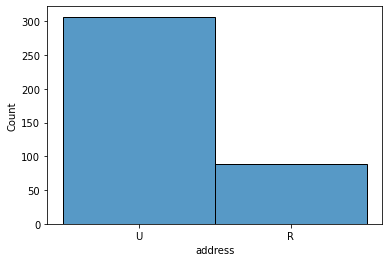

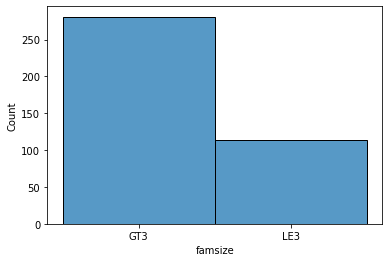

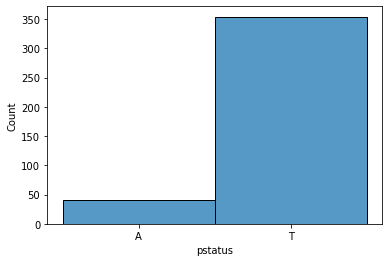

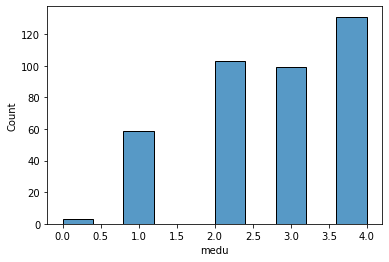

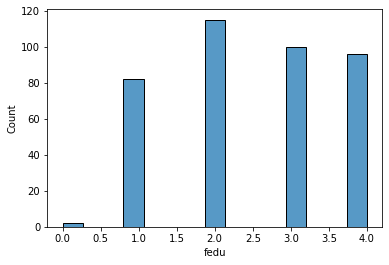

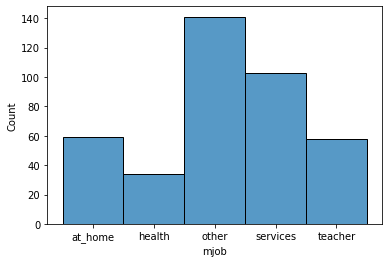

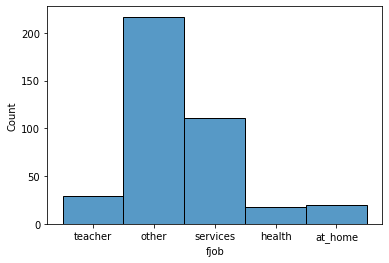

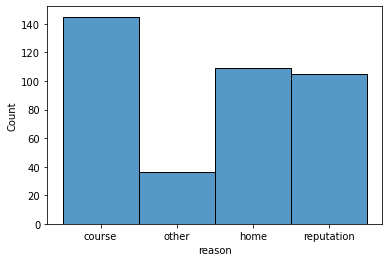

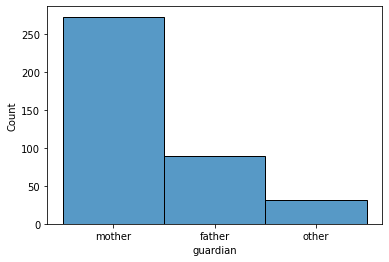

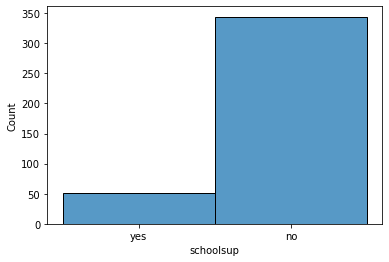

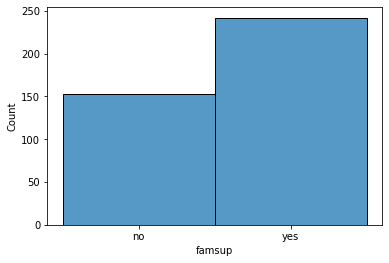

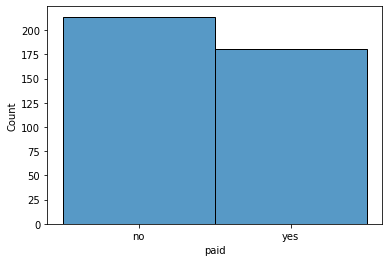

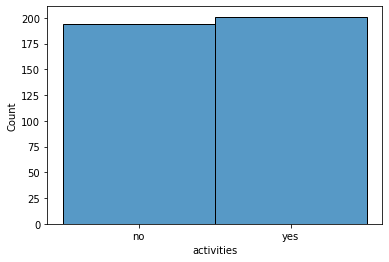

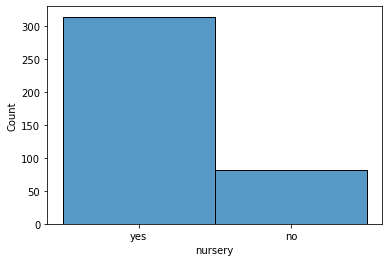

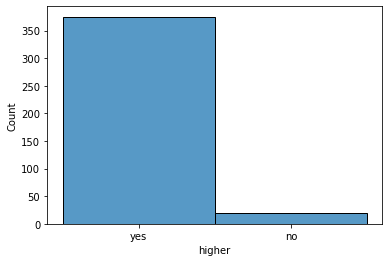

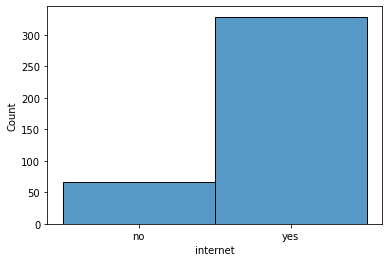

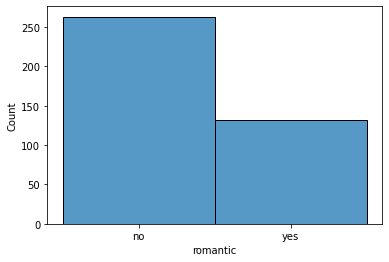

<Figure size 432x288 with 0 Axes>

In [51]:
for i in categoricals.columns:
    sns.histplot(categoricals[i])
    plt.figure(i)

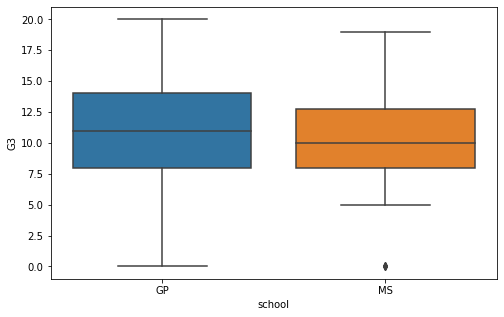

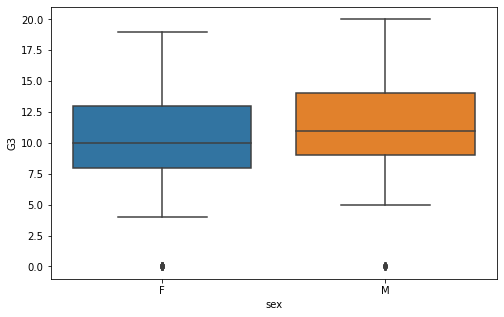

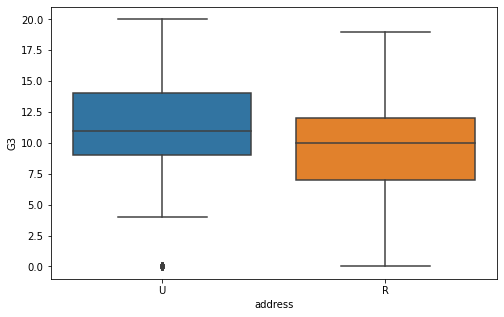

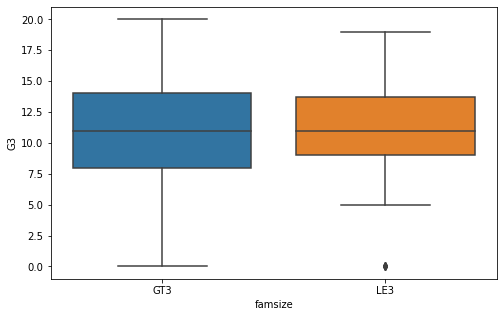

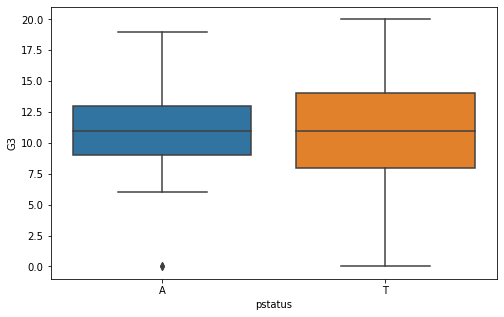

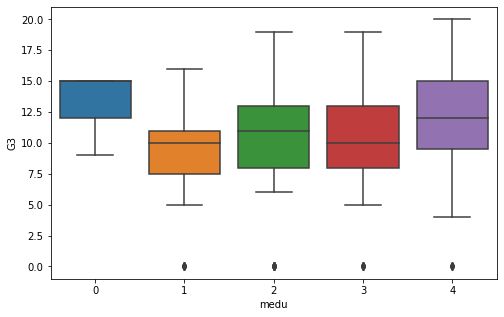

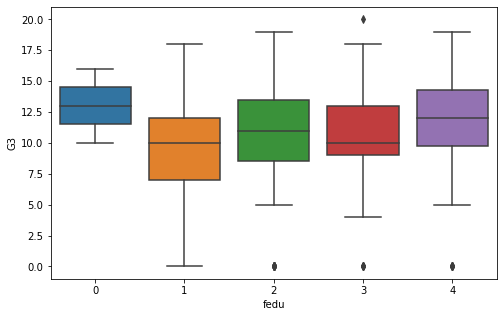

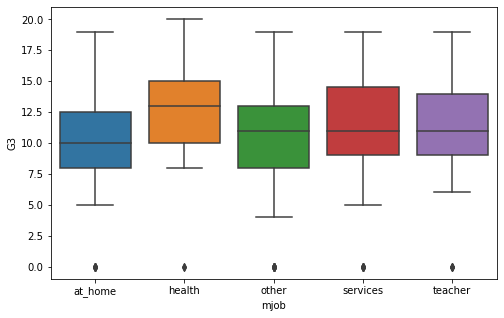

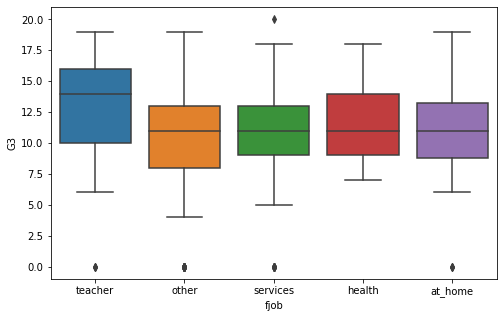

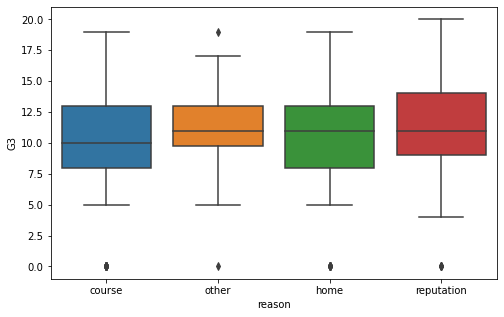

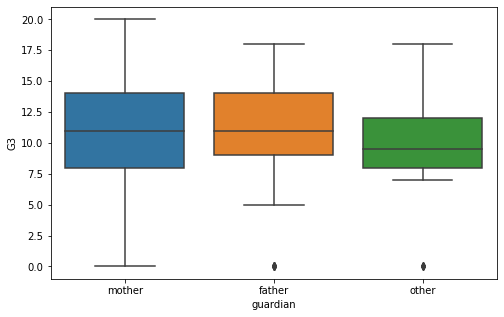

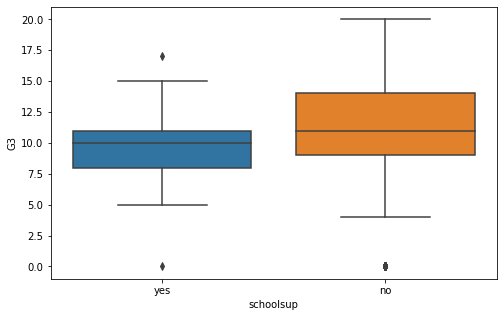

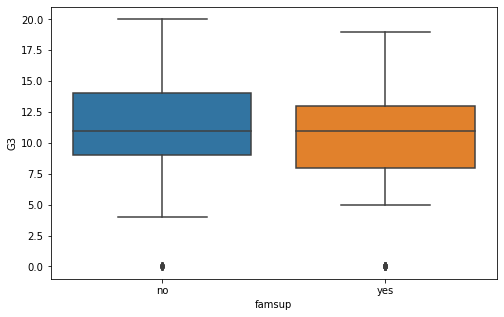

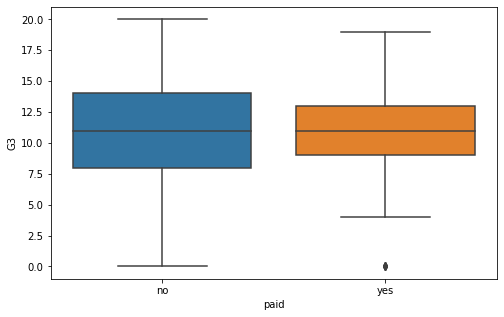

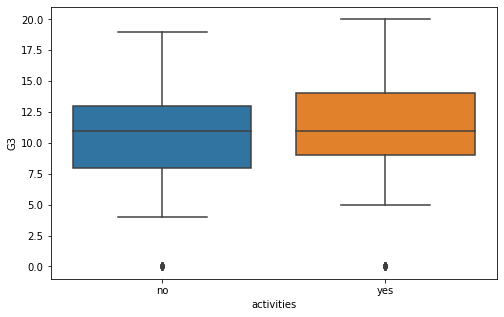

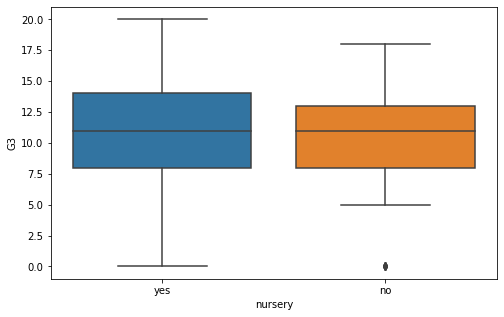

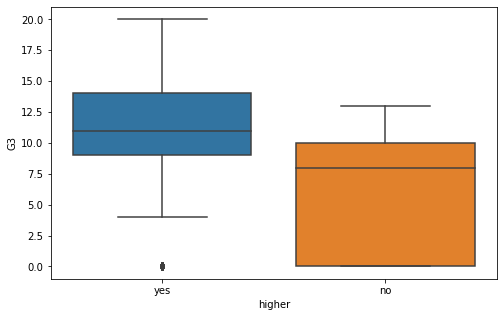

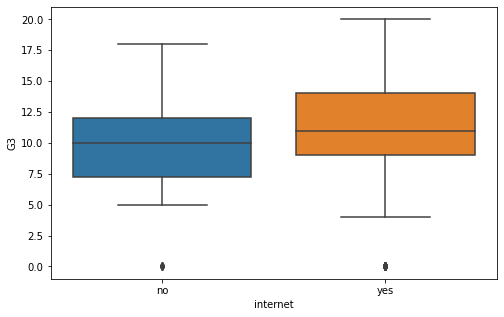

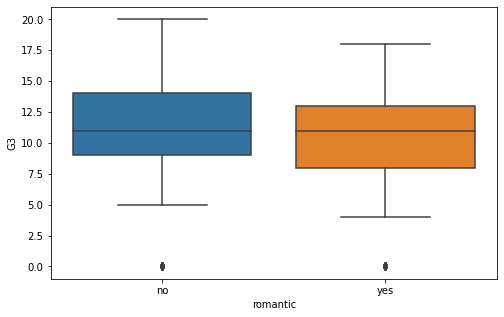

In [52]:

for col in categoricals:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=categoricals[col], y=data['G3'])

    plt.show()

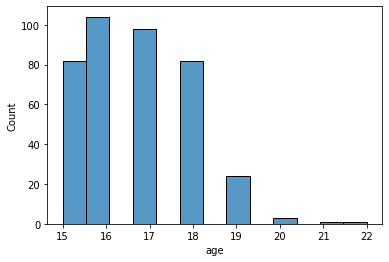

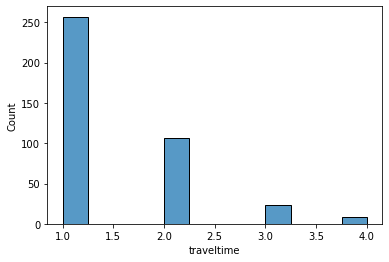

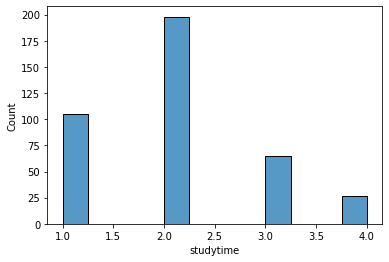

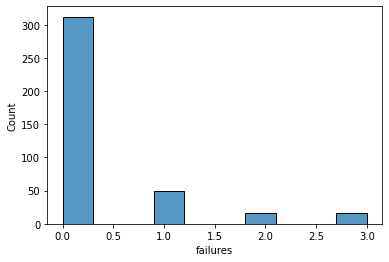

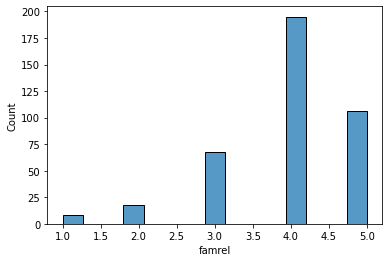

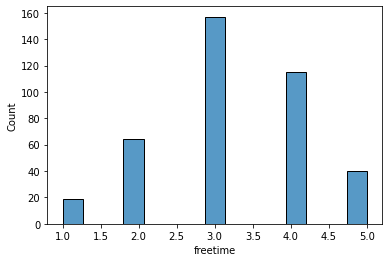

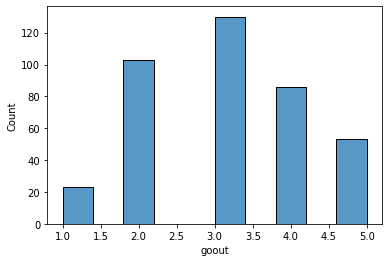

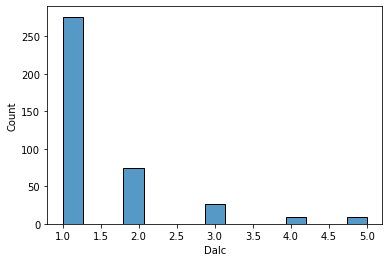

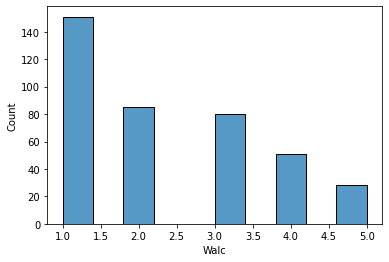

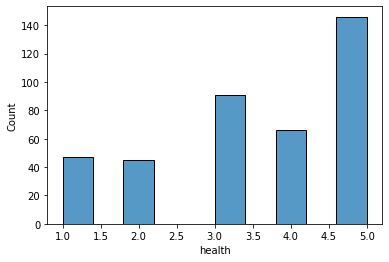

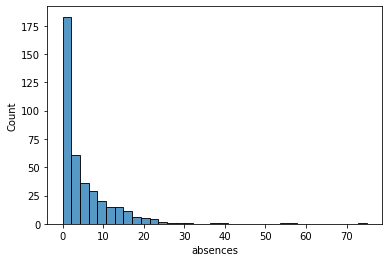

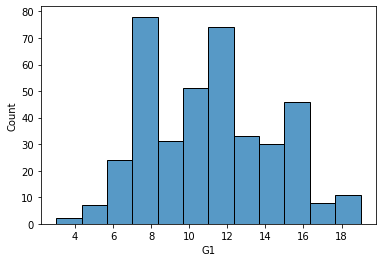

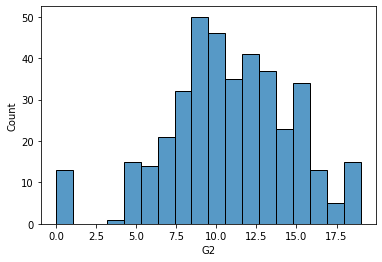

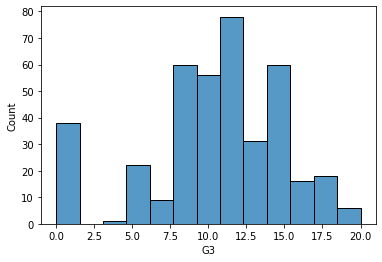

In [53]:
for head in numerical.columns:
    sns.histplot(numerical[head])

    plt.show()

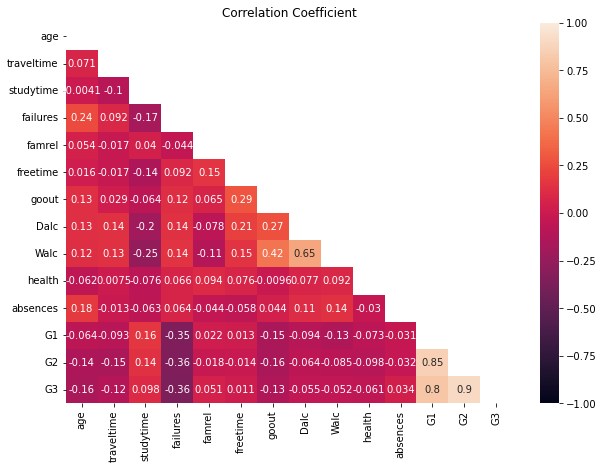

In [54]:
# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(numerical.corr(), dtype=bool))

# generate heatmap
sns.heatmap(numerical.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient')

plt.show()

In [55]:
#dropping unknown data at the begining of the corse
data = data.drop(['absences'], axis = 1)

In [56]:
#dropping G1 and G2 because I'm only using the final grade G3 
data = data.drop(['G1','G2'], axis = 1)

In [57]:
data[data['paid']!='yes']

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,6
6,GP,M,16,U,LE3,T,2,2,other,other,...,yes,yes,no,4,4,4,1,1,3,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,yes,no,no,4,1,4,1,1,1,6
11,GP,F,15,U,GT3,T,2,1,services,other,...,yes,yes,no,5,2,2,1,1,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,MS,F,18,U,GT3,T,1,1,other,other,...,yes,no,no,1,1,1,1,1,5,0
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,yes,no,2,4,5,3,4,2,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,yes,no,no,5,5,3,3,3,3,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,yes,no,4,4,1,3,4,5,10


In [58]:
#checking the distribution paid students
data['paid'].value_counts()

no     214
yes    181
Name: paid, dtype: int64

<AxesSubplot:xlabel='paid', ylabel='Count'>

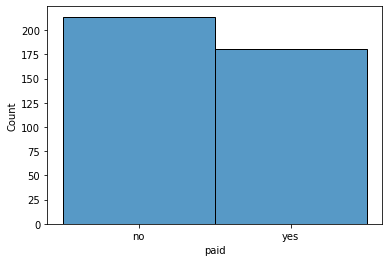

In [59]:
sns.histplot(data['paid'])


In [60]:
#In this case I'm dropping the paid class students for consistency knowing that I'm loosing a lot of data

In [61]:
data = data[data['paid']!='yes']

In [62]:
data = data.drop(['paid'],axis = 1)

In [63]:
#creating a new column recommendation
data['recommendation'] = data.apply(f1, axis=1)

In [64]:
#dropping G3 as it has a direct correlation with recommendation
data = data.drop(['G3'],axis = 1)

In [65]:
#checking target imbalance 
data['recommendation'].value_counts()

YES    135
NO      79
Name: recommendation, dtype: int64

<AxesSubplot:xlabel='recommendation', ylabel='Count'>

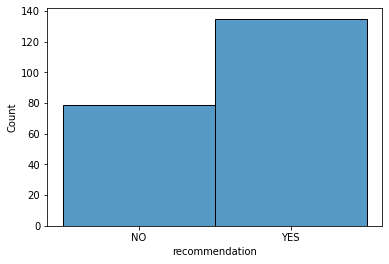

In [66]:
sns.histplot(data['recommendation'])


In [67]:
#there is a minor imbalance problem with this data, using TomekLinks to reduce it and increase separation

Xf=data.drop(['recommendation'], axis=1)
y=data['recommendation']
Xf_num=Xf.select_dtypes(include = np.number)
Xf_cat = pd.get_dummies(Xf.select_dtypes(include = 'object'), drop_first=True)
Xf=pd.concat([Xf_num, Xf_cat], axis=1)


tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(Xf, y)
y_tl.value_counts()


unique, counts = np.unique(y_tl, return_counts=True)
print(np.asarray((unique, counts)).T)

[['NO' 79]
 ['YES' 120]]


In [68]:
#Splitting the data for model training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=42)

# testing different classification models

In [69]:
clf = RandomForestClassifier(max_depth=8, random_state=32)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(classification_report(y_test, predicted))
print(accuracy_score(y_test, predicted , normalize=False))

              precision    recall  f1-score   support

          NO       0.60      0.43      0.50        28
         YES       0.60      0.75      0.67        32

    accuracy                           0.60        60
   macro avg       0.60      0.59      0.58        60
weighted avg       0.60      0.60      0.59        60

36


In [70]:
model = DecisionTreeClassifier(random_state=32)
model.fit( X_train, y_train )
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          NO       0.54      0.46      0.50        28
         YES       0.58      0.66      0.62        32

    accuracy                           0.57        60
   macro avg       0.56      0.56      0.56        60
weighted avg       0.56      0.57      0.56        60



In [71]:
model = LogisticRegression(max_iter = 1500)
model.fit( X_train, y_train )
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          NO       0.65      0.61      0.63        28
         YES       0.68      0.72      0.70        32

    accuracy                           0.67        60
   macro avg       0.67      0.66      0.66        60
weighted avg       0.67      0.67      0.67        60



# Logistic regression is working better

In [72]:
mat_model = model
predicted = mat_model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          NO       0.65      0.61      0.63        28
         YES       0.68      0.72      0.70        32

    accuracy                           0.67        60
   macro avg       0.67      0.66      0.66        60
weighted avg       0.67      0.67      0.67        60



In [73]:
mat_data = Xf.copy()

# Joining both dataframes and using the models to create the recomendation columns

In [74]:
alldata = pd.concat([mat_data, por_data], axis=0)

In [75]:
#there are some students that are in both dataframes so dropping duplicates is needed
alldata.drop_duplicates(inplace = True, keep=False)


In [76]:
alldata['por_rec'],alldata['math_rec'] = por_model.predict(alldata), mat_model.predict(alldata)

In [77]:
alldata

,age,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,...,guardian_other,schoolsup_yes,famsup_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,por_rec,math_rec
18,17,1,1,3,5,5,5,2,4,5,...,0,0,1,1,1,1,1,0,NO,NO
28,16,1,2,0,5,3,3,1,1,5,...,0,1,1,1,1,1,1,0,YES,YES
40,16,2,2,1,3,3,3,1,2,3,...,0,0,1,1,0,1,1,1,YES,YES
49,15,1,2,1,4,4,4,1,1,3,...,0,1,1,1,0,1,1,0,YES,YES
52,15,2,1,1,5,5,5,3,4,5,...,0,0,0,0,1,1,0,0,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,18,2,3,0,5,3,3,1,3,4,...,0,0,0,0,1,1,0,0,YES,YES
642,17,2,2,0,5,5,4,1,1,1,...,0,0,0,0,1,1,1,0,YES,YES
643,18,3,1,0,4,4,3,2,2,5,...,0,0,1,1,1,1,1,1,YES,NO
645,18,1,2,0,4,3,4,1,1,1,...,0,0,1,0,1,1,1,0,YES,NO


In [78]:
#saving the end data
alldata.to_csv('alldata.csv', index=False)  